In [66]:
# 딥러닝 Review

In [67]:
# 필수 라이브러리
import pandas as pd
import numpy as np
import random
import tensorflow as tf

In [68]:
# 랜덤시드고정 : 테스트할때마다 동일한 데이터를 가지고 학습하기위해서 랜덤값을 고정
# 파일 읽어오기
drive_path = './wine/data/'
train = pd.read_csv(drive_path+'train.csv')
test = pd.read_csv(drive_path+'test.csv')
submission = pd.read_csv(drive_path+'sample_submission.csv')
train.shape, test.shape, submission.shape

((5497, 14), (1000, 13), (1000, 2))

In [69]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [70]:
submission.head()  # 제출파일... quality 컬럼에 최종 예측한 값을 넣어서 제출

,index,quality
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [71]:
# 와인의 전반적인 정보취득... type의 데이터 본다.
train['type'].value_counts()

white    4159
red      1338
Name: type, dtype: int64

In [72]:
white_index = train[train['type'] == 'white'].index
red_index = train[train['type'] == 'red'].index
train.loc[white_index,['type']] = 1
train.loc[red_index,['type']] = 0
#숫자로 타입을 변경
train['type'] = train['type'].astype(int)

test['type'] =  np.where(test['type'] == 'white',1,0).astype(int)

In [73]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   int32  
dtypes: float64(11), int32(1), int64(2)
memory usage: 579.9 KB


In [74]:
# 레이블 : 정답데이터, 목표변수
train['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64

In [75]:
# 레이블 즉 정답 또는 목표변수가 두가지 타입이아니라 3개 이상이면 서로 영향을 주는 형태의 숫자이기때문에
# one - hot - incoding을 실시한다
# 1 2 3
# 100
# 010
# 001
# 3을 차감해서 와인등급을 0 ~ 6 범위로 변경
(train.loc[:,'quality']-3).value_counts()

3    2416
2    1788
4     924
1     186
5     152
0      26
6       5
Name: quality, dtype: int64

In [76]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train.loc[:,'quality']-3)
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [77]:
# sns.heatmap(corr.values,# 데이터
#                           cbar = True, # 오른쪽 컬러 막대 출력 여부
#                           annot = True, # 차트에 상관계수 값을 보여줄 것인지 여부
#                           annot_kws={'size' : 20}, # 숫자 출력 시 숫자 크기 조절
#                            fmt = '.3f', # 숫자의 출력 소수점자리 개수 조절
#                            square = 'True', # 차트를 정사각형으로 할 것인지
#                           yticklabels=corr_column_names, # y축에 컬럼명 출력
#                           xticklabels=corr_column_names) # x축에 컬럼명 출력


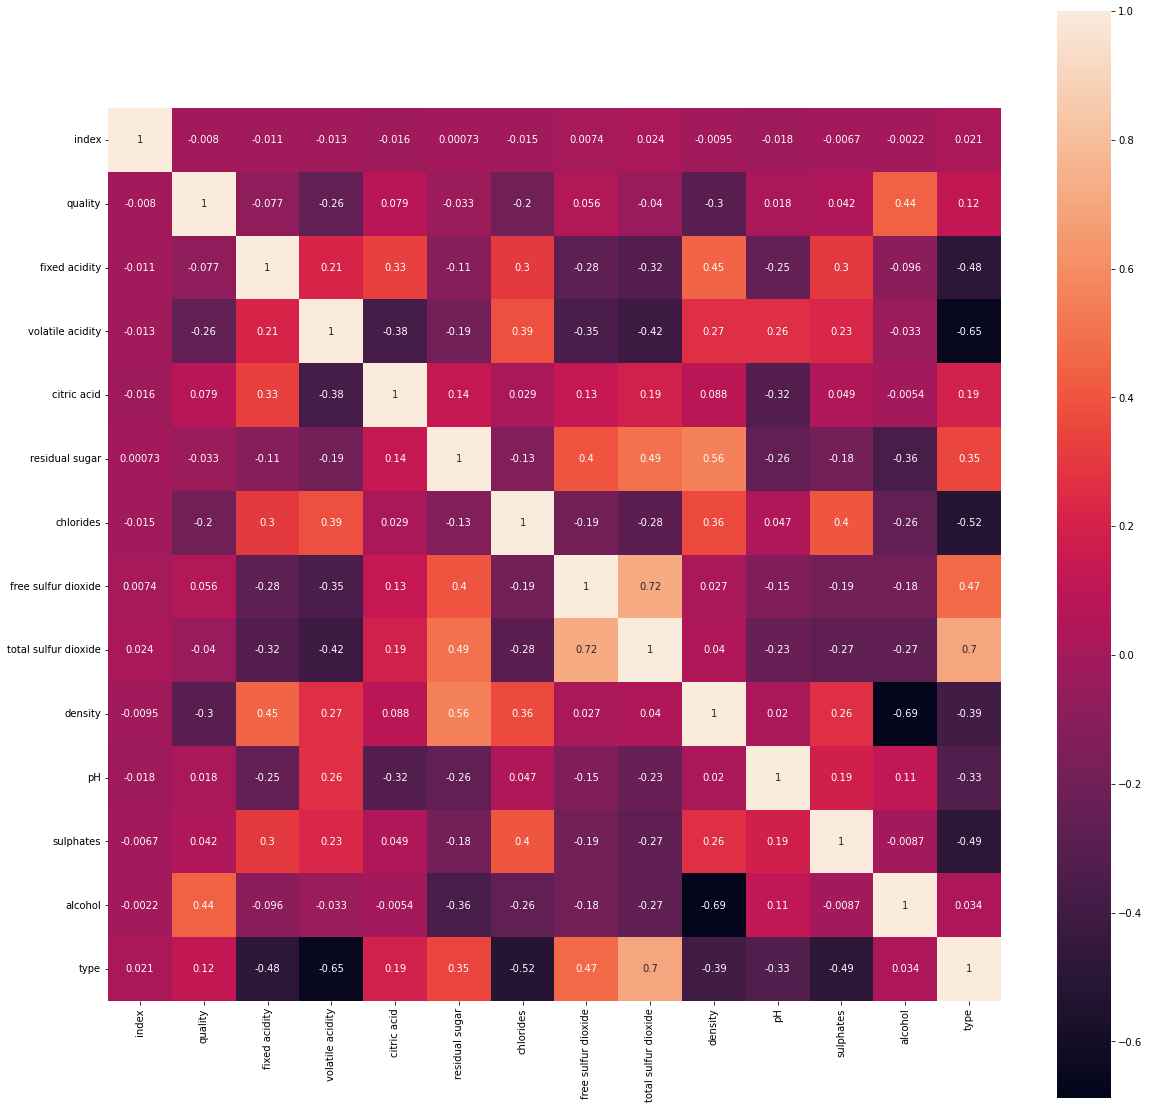

In [78]:
# 참고용...
import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True,square=True)
plt.show()

In [79]:
# 학습데이터를 추출
x_train =  train.loc[:,'fixed acidity':]
x_test = test.loc[:,'fixed acidity':]

# 피처 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

x_train.shape, x_train_scaled.shape, x_test.shape, x_test_scaled.shape

((5497, 12), (5497, 12), (1000, 12), (1000, 12))

In [80]:
# 모델 설계 - 신경망으로 설계
# 완전 연결 레이어(Dense) : 4  과적합을 피하기위해 dropout 추가


In [84]:
# 신경망 모델
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
def build_model(train_data, train_target):
    model = Sequential()
    model.add(Dense(128,activation='tanh', input_dim = train_data.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(train_target.shape[1],activation='softmax'))
    model.compile(optimizer = 'adam', loss='categorical_crossentropy',metrics=['acc','mae'])
    return model
model = build_model(x_train_scaled,y_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1664      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 7)                 231       
                                                                 
Total params: 12,231
Trainable params: 12,231
Non-trai

In [85]:
# 콜백함수 Early Stopping 기법
# 과적합이 발생하기전에 stop : 일정 에코크동안 성능이 정채될때(좋아지지 않을때) 이때 허용되는 에포크수
# patience 옵션

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
x_tr,x_val,y_tr,y_val =  train_test_split(x_train_scaled,y_train, test_size=0.15, random_state=42)
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 10)
history = model.fit(x_tr, y_tr,batch_size=64, epochs=200,
                   validation_data=(x_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/200
73/73 [==============================] - 1s 4ms/step - loss: 1.3242 - acc: 0.4568 - mae: 0.1953 - val_loss: 1.2009 - val_acc: 0.4824 - val_mae: 0.1835
Epoch 2/200
73/73 [==============================] - 0s 2ms/step - loss: 1.1774 - acc: 0.4921 - mae: 0.1790 - val_loss: 1.1472 - val_acc: 0.5030 - val_mae: 0.1754
Epoch 3/200
73/73 [==============================] - 0s 2ms/step - loss: 1.1377 - acc: 0.5060 - mae: 0.1731 - val_loss: 1.1317 - val_acc: 0.4982 - val_mae: 0.1713
Epoch 4/200
73/73 [==============================] - 0s 2ms/step - loss: 1.1189 - acc: 0.5306 - mae: 0.1712 - val_loss: 1.1199 - val_acc: 0.5200 - val_mae: 0.1713
Epoch 5/200
73/73 [==============================] - 0s 2ms/step - loss: 1.1211 - acc: 0.5225 - mae: 0.1713 - val_loss: 1.1146 - val_acc: 0.5164 - val_mae: 0.1709
Epoch 6/200
73/73 [==============================] - 0s 2ms/step - loss: 1.0975 - acc: 0.5385 - mae: 0.1692 - val_loss: 1.1101 - val_acc: 0.5224 - val_mae: 0.1699
Epoch 7/200
73/73 [===

In [88]:
model.evaluate(x_val, y_val)

26/26 [==============================] - 0s 1ms/step - loss: 1.0519 - acc: 0.5442 - mae: 0.1634


[1.0518656969070435, 0.5442424416542053, 0.16342344880104065]

In [89]:
# test 데이터에 대한 예측값 정리
y_pred_proba = model.predict(x_test)
y_pred_proba[:5]

32/32 [==============================] - 0s 713us/step


array([[0.24013282, 0.00567759, 0.03135345, 0.0531606 , 0.13489759,
        0.33410022, 0.20067775],
       [0.28149873, 0.00206523, 0.00969656, 0.02752979, 0.11703593,
        0.2033697 , 0.35880408],
       [0.27432233, 0.01774901, 0.07639445, 0.07532484, 0.1258941 ,
        0.2296274 , 0.2006879 ],
       [0.24473922, 0.03280017, 0.13782173, 0.09758695, 0.12600112,
        0.21815696, 0.14289385],
       [0.288001  , 0.00501454, 0.01777888, 0.04058054, 0.1390885 ,
        0.26580596, 0.24373055]], dtype=float32)

In [95]:
# np.argmax 함수를 사용
y_pred_label = np.argmax(y_pred_proba,axis=-1)+3

In [97]:
y_pred_label[:6]

array([5, 6, 0, 0, 0, 0], dtype=int64)

In [98]:
submission['quality'] = y_pred_label.astype(int)
submission.head()

,index,quality
0,0,5
1,1,6
2,2,0
3,3,0
4,4,0


In [99]:
submission.to_csv(drive_path+'wine_001.csv', index=False)

'./wine/data/'